In [ ]:
from src.shared_imports import *

plt.style.use("seaborn-v0_8")

In [ ]:
df = pd.read_csv("data/processed/gen_sen_merged.csv")
df = df.drop(['HOUR_x', 'DATE_x'], axis=1)
df["DATE_TIME"] = pd.to_datetime(df["DATE_TIME"])
df["DAY"] = df["DATE_TIME"].dt.date

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            68778 non-null  datetime64[ns]
 1   SOURCE_KEY_x         68778 non-null  object        
 2   DC_POWER             68778 non-null  float64       
 3   AC_POWER             68778 non-null  float64       
 4   DAILY_YIELD          68778 non-null  float64       
 5   TOTAL_YIELD          68778 non-null  float64       
 6   INVERTER_EFF         36827 non-null  float64       
 7   AMBIENT_TEMPERATURE  68774 non-null  float64       
 8   MODULE_TEMPERATURE   68774 non-null  float64       
 9   IRRADIATION          68774 non-null  float64       
 10  DAY                  68778 non-null  object        
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 5.8+ MB


The modeling features (IRR, temperature, DC, and AC) have almost no missing values, with only four records containing missing data. These missing values are negligible for model training and are handled using forward fill.

The large number of NaN values in INVERTER_EFF is caused by division by zero when DC_POWER equals zero. Since this metric is not used as a model input, no additional cleaning is required and it does not affect model training.

## 2.1 Baseline DC Power Model

We use a simple linear model to estimate the expected DC power output of PV modules under normal operating conditions:

DC_POWER = a × IRR + b × MODULE_TEMPERATURE + c + ε

The rationale is straightforward:
- Higher irradiance → higher DC output (positive correlation)
- Higher temperature → reduced module efficiency → slightly lower DC output (negative correlation)

Therefore, irradiance and temperature together can effectively capture the physical variation of DC power.
The constant term c represents systematic offsets (e.g., installation differences or sensor bias),
while the noise term ε captures short-term random fluctuations.

**We use a linear model not because machine learning is insufficient, but because the physical process of PV generation can be accurately described in a linear form. Linear models offer interpretability, stability, robustness, deployability, and auditability, and are a standard approach in the photovoltaic industry for baseline modeling and fault detection.**


In [ ]:
df_copy = df.copy()
df_copy['DATE_TIME']= pd.to_datetime(df_copy['DATE_TIME'],format='%d-%m-%Y %H:%M')

<Figure size 1500x500 with 0 Axes>

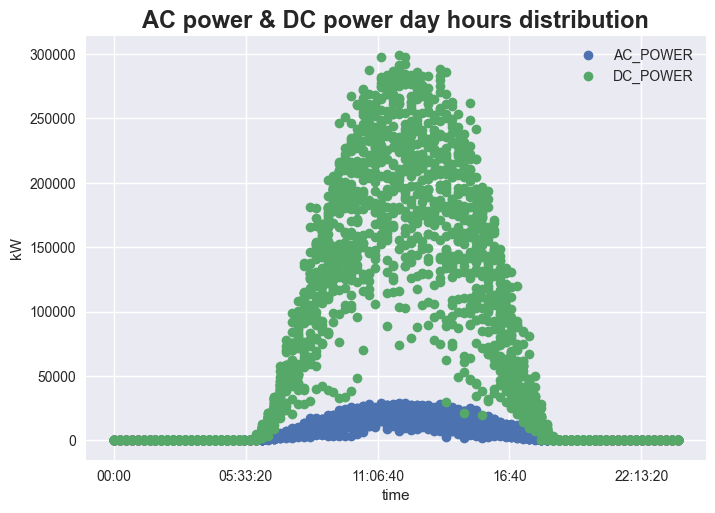

In [ ]:
df_copy = df_copy.groupby("DATE_TIME")[['AC_POWER','DC_POWER']].sum().reset_index()
df_copy['time']=df_copy['DATE_TIME'].dt.time
plt.figure(figsize=(15,5))
df_copy.set_index('time')[['AC_POWER','DC_POWER']].plot(style='o')

plt.title("AC power & DC power day hours distribution",fontsize=17,weight="bold")
plt.xlabel("time")
plt.ylabel("kW")
plt.grid(True)

A large number of zero-value data points are observed during nighttime. Since these zeros would affect the regression, they are removed during model training.  
The small amount of missing data is handled using forward interpolation.

### Global DC Baseline Regression Model

In [ ]:
df = df.sort_values(["DATE_TIME"])
df["AMBIENT_TEMPERATURE"] = df["AMBIENT_TEMPERATURE"].fillna(method="ffill")
df["MODULE_TEMPERATURE"] = df["MODULE_TEMPERATURE"].fillna(method="ffill")
df["IRRADIATION"] = df["IRRADIATION"].fillna(method="ffill")

(df["AMBIENT_TEMPERATURE"] == 0).sum()

C:\Users\pearl\AppData\Local\Temp\ipykernel_9816\2230140758.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["AMBIENT_TEMPERATURE"] = df["AMBIENT_TEMPERATURE"].fillna(method="ffill")
C:\Users\pearl\AppData\Local\Temp\ipykernel_9816\2230140758.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["MODULE_TEMPERATURE"] = df["MODULE_TEMPERATURE"].fillna(method="ffill")
C:\Users\pearl\AppData\Local\Temp\ipykernel_9816\2230140758.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["IRRADIATION"] = df["IRRADIATION"].fillna(method="ffill")


np.int64(0)

In [ ]:
zero_m = (df["MODULE_TEMPERATURE"] == 0).sum()
zero_I = (df["IRRADIATION"] == 0).sum()
zero_D = (df["DC_POWER"] == 0).sum()

In [ ]:
k = (df["IRRADIATION"]>0.1).sum()
print(k)

30722


In [ ]:
print(zero_m,zero_I,zero_D)

0 30398 31951


In [ ]:
from sklearn.linear_model import LinearRegression
df["DC_POWER"] = df["DC_POWER"] / 1000
df["IRRADIATION"] = df["IRRADIATION"] * 1000

irr_thr = df["IRRADIATION"].max() * 0.15
dc_thr = df["DC_POWER"].max() * 0.05

df_model = df[(df["IRRADIATION"] > irr_thr) &
              (df["DC_POWER"] > dc_thr) &
              (df["MODULE_TEMPERATURE"] > 10)]

X = df_model[["IRRADIATION", "MODULE_TEMPERATURE"]]
y = df_model["DC_POWER"]

model = LinearRegression().fit(X, y)

a, b = model.coef_
c = model.intercept_

print("=== Physical DC Baseline Model ===")
print("a (Irradiance Coefficient) =", a)
print("b (Temperature Coefficient) =", b)
print("c (Bias Term) =", c)

df["DC_BASELINE"] = model.predict(df[["IRRADIATION", "MODULE_TEMPERATURE"]])


=== Physical DC Baseline Model ===
a (光照系数) = 0.012403439171303435
b (温度系数) = -0.0014594804273644294
c (偏置) = 0.7118102489836273


In [ ]:
df.head()

,DATE_TIME,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,INVERTER_EFF,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,DC_BASELINE
0,2020-05-15,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,NaN,25.184316,22.857507,0.0,2020-05-15,0.67845
20,2020-05-15,zVJPv84UY57bAof,0.0,0.0,0.0,7116151.0,NaN,25.184316,22.857507,0.0,2020-05-15,0.67845
19,2020-05-15,zBIq5rxdHJRwDNY,0.0,0.0,0.0,6339380.0,NaN,25.184316,22.857507,0.0,2020-05-15,0.67845
18,2020-05-15,z9Y9gH1T5YWrNuG,0.0,0.0,0.0,7007866.0,NaN,25.184316,22.857507,0.0,2020-05-15,0.67845
17,2020-05-15,wCURE6d3bPkepu2,0.0,0.0,0.0,6782598.0,NaN,25.184316,22.857507,0.0,2020-05-15,0.67845


计算模型的MAE,RMSE,R2

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_true = df["DC_POWER"]
y_pred = df["DC_BASELINE"]

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("MAE =", mae)
print("RMSE =", rmse)
print("R² =", r2)

MAE = 0.6013166510679797
RMSE = 0.575337651970306
R² = 0.9646875041542526


本次线性基线模型的评估结果显示，R² 为 0.9647，说明模型能够解释约 96.5% 的 DC 输出功率变化，整体拟合度较高。MAE（0.0006）与 RMSE（5.7e-07）数值非常小，主要由于建模前对数据进行了缩放处理，因此其绝对值不具有直接的物理意义。

### 看拟合程度，画真实值 vs 预测值散点图

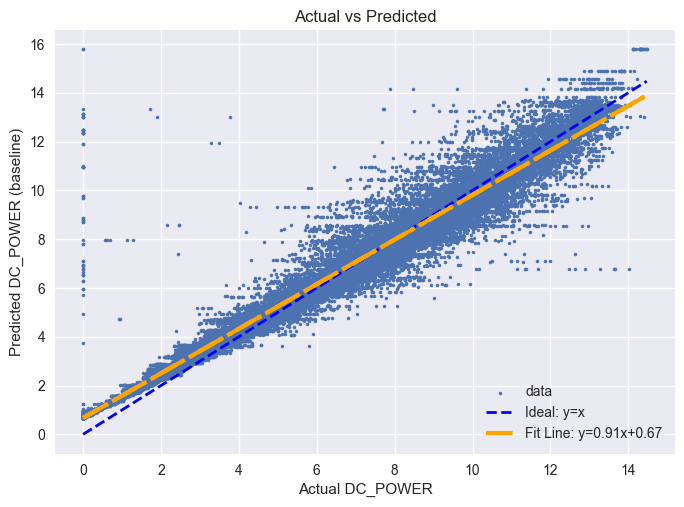

In [ ]:
plt.scatter(y_true, y_pred, s=5, label="data")
k,b = np.polyfit(y_true, y_pred, 1)
k_fit = k*y_true + b

x_line = np.linspace(min(y_true), max(y_true), 100)
plt.plot(x_line, x_line, color="blue", linestyle="--", linewidth=2, label="Ideal: y=x")

plt.plot(y_true, k_fit, color="orange", linestyle="-.", linewidth=3, label=f"Fit Line: y={k:.2f}x+{b:.2f}")
plt.xlabel("Actual DC_POWER")
plt.ylabel("Predicted DC_POWER (baseline)")
plt.title("Actual vs Predicted")
plt.legend()

橘色拟合线和45度对角线几乎重叠，模型对大多数数据预测良好
拟合线较真实线稍微平缓，说明有轻微低估的趋势，实际 DC_POWER 比模型预测的稍高，这可能是真实组件比线性模型预期表现更好

### 画残差图

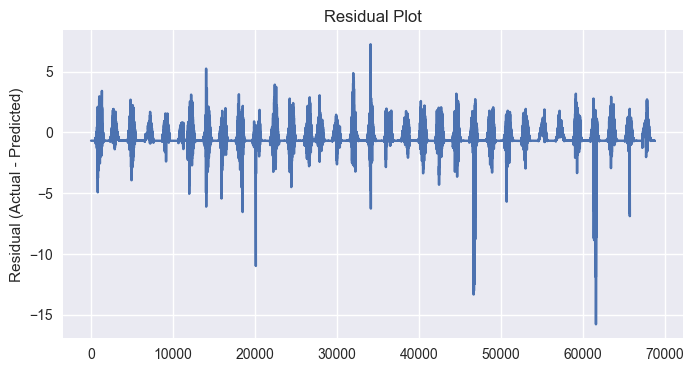

In [ ]:
residual = y_true - y_pred
plt.figure(figsize=(8,4))
plt.plot(residual)
plt.title("Residual Plot")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)

残差呈现周期性波动，且主要集中在±0.002 范围内，模型相对稳定。偶发极端尖刺是正常的离群值，通常来自云层突发遮挡，传感器噪音等。

Text(0.5, 1.0, 'Residual Histogram')

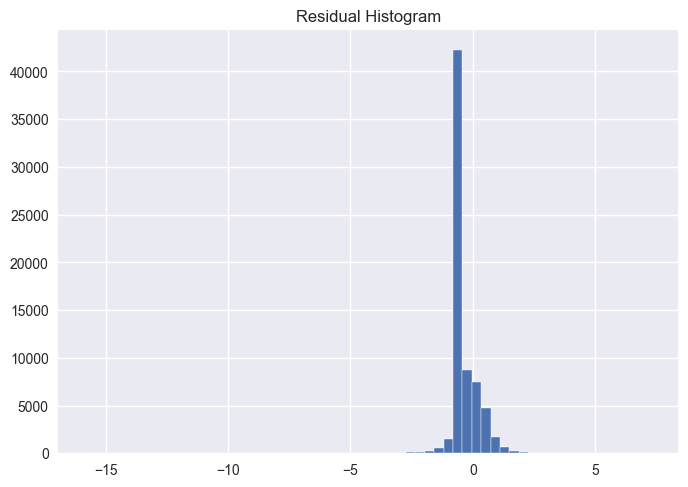

In [ ]:
plt.hist(residual, bins=60)
plt.title("Residual Histogram")